### Import packages

In [7]:
import itertools
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split

from utilities import cal_score, convert_types

/usr/local/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


### Columns

In [2]:
cols_num = ['txn_dt', 'total_floor', 'building_complete_dt', 'parking_area', 'parking_price', 'txn_floor', 'land_area', 'building_area', 'lat', 'lon', 'village_income_median', 'town_population', 'town_area', 'town_population_density', 'doc_rate', 'master_rate', 'bachelor_rate', 'jobschool_rate', 'highschool_rate', 'junior_rate', 'elementary_rate', 'born_rate', 'death_rate', 'marriage_rate', 'divorce_rate', 'N_50', 'N_500', 'N_1000', 'N_5000', 'N_10000', 'I_10', 'I_50', 'I_100', 'I_250', 'I_500', 'I_1000', 'I_5000', 'I_10000', 'I_MIN', 'II_10', 'II_50', 'II_100', 'II_250', 'II_500', 'II_1000', 'II_5000', 'II_10000', 'II_MIN', 'III_10', 'III_50', 'III_100', 'III_250', 'III_500', 'III_1000', 'III_5000', 'III_10000', 'III_MIN', 'IV_10', 'IV_50', 'IV_100', 'IV_250', 'IV_500', 'IV_1000', 'IV_5000', 'IV_10000', 'IV_MIN', 'V_10', 'V_50', 'V_100', 'V_250', 'V_500', 'V_1000', 'V_5000', 'V_10000', 'V_MIN', 'VI_50', 'VI_100', 'VI_250', 'VI_500', 'VI_1000', 'VI_5000', 'VI_10000', 'VI_MIN', 'VII_10', 'VII_50', 'VII_100', 'VII_250', 'VII_500', 'VII_1000', 'VII_5000', 'VII_10000', 'VII_MIN', 'VIII_10', 'VIII_50', 'VIII_100', 'VIII_250', 'VIII_500', 'VIII_1000', 'VIII_5000', 'VIII_10000', 'VIII_MIN', 'IX_10', 'IX_50', 'IX_100', 'IX_250', 'IX_500', 'IX_1000', 'IX_5000', 'IX_10000', 'IX_MIN', 'X_10', 'X_50', 'X_100', 'X_250', 'X_500', 'X_1000', 'X_5000', 'X_10000', 'X_MIN', 'XI_10', 'XI_50', 'XI_100', 'XI_250', 'XI_500', 'XI_1000', 'XI_5000', 'XI_10000', 'XI_MIN', 'XII_10', 'XII_50', 'XII_100', 'XII_250', 'XII_500', 'XII_1000', 'XII_5000', 'XII_10000', 'XII_MIN', 'XIII_10', 'XIII_50', 'XIII_100', 'XIII_250', 'XIII_500', 'XIII_1000', 'XIII_5000', 'XIII_10000', 'XIII_MIN', 'XIV_10', 'XIV_50', 'XIV_100', 'XIV_250', 'XIV_500', 'XIV_1000', 'XIV_5000', 'XIV_10000', 'XIV_MIN']
cols_cat = ['building_material', 'city', 'building_type', 'building_use', 'parking_way', 'town', 'village']
cols_bin = ['I_index_50', 'I_index_500', 'I_index_1000', 'II_index_50', 'II_index_500', 'II_index_1000', 'III_index_50', 'III_index_500', 'III_index_1000', 'IV_index_50', 'IV_index_500', 'IV_index_1000', 'IV_index_5000', 'V_index_50', 'V_index_500', 'V_index_1000', 'VI_10', 'VI_index_50', 'VI_index_500', 'VI_index_1000', 'VII_index_50', 'VII_index_500', 'VII_index_1000', 'VIII_index_50', 'VIII_index_500', 'VIII_index_1000', 'IX_index_50', 'IX_index_500', 'IX_index_1000', 'IX_index_5000', 'X_index_50', 'X_index_500', 'X_index_1000', 'XI_index_50', 'XI_index_500', 'XI_index_1000', 'XI_index_5000', 'XI_index_10000', 'XII_index_50', 'XII_index_500', 'XII_index_1000', 'XIII_index_50', 'XIII_index_500', 'XIII_index_1000', 'XIII_index_5000', 'XIII_index_10000', 'XIV_index_50', 'XIV_index_500', 'XIV_index_1000']
cols_feats = cols_num + cols_cat + cols_bin

col_target = 'total_price'
col_target_log1p = 'target'

### Read data

In [3]:
df = pd.read_csv('../dataset/train.csv', dtype=object)

In [4]:
df.columns

Index(['building_id', 'building_material', 'city', 'txn_dt', 'total_floor',
       'building_type', 'building_use', 'building_complete_dt', 'parking_way',
       'parking_area',
       ...
       'XIV_500', 'XIV_index_500', 'XIV_1000', 'XIV_index_1000', 'XIV_5000',
       'XIV_index_5000', 'XIV_10000', 'XIV_index_10000', 'XIV_MIN',
       'total_price'],
      dtype='object', length=235)

### Preprocessing

In [5]:
# Convert types
df = convert_types(df, cols_num, col_target=col_target)

# Generate feats (train-test-same feats)
#create_feats(df)

### Target transform

In [6]:
def target_transform(df):  # Add new columns inplace!!
    '''Transform the original target to the target for model to train on'''
    df['log_total_price'] = np.log1p(df['total_price']/df['building_area'])
    return df

def target_inverse_transform(df, y_pred):
    '''Inverse transorform the model target to the original target of our problem'''
    y_pred = pd.Series(y_pred.copy())
    y_pred_expm1 = np.expm1(y_pred)
    y_pred_final = np.clip(y_pred_expm1, 0, None)
    y_pred_final = y_pred_final * df['building_area'].reset_index(drop=True)
    return y_pred_final.values

In [7]:
df = target_transform(df)

In [8]:
# transformed target fit by the model
col_model_target = 'log_total_price'
#col_model_target = 'total_price'

### Feat engineering

In [9]:
from feature_engineering import CategoricalColumnsEncoder

In [10]:
class FeatureEngineering():
    def __init__(self):
        pass
    
    def fit_transform(self, df, cols_cat, cols_bin):
        df = df.copy()
        # Denote categorical-type
        self.cat_encoder = CategoricalColumnsEncoder(mode='pandas')
        self.cat_encoder.fit_transform(df, cols_cat+cols_bin)
        return df
    
    def transform(self, df):
        df = df.copy()
        self.cat_encoder.transform(df)
        return df

### Grid search

In [11]:
# grid search
params_fix = {'task': 'train',
              'boosting_type': 'gbdt',
              'objective': 'mse',
              'metric': 'mape',
              'learning_rate': 0.015,
              'num_leaves': 255,
              'feature_fraction': 0.5,
              'min_data_in_leaf': 5,
              'lambda_l1': 0.1,
             }
lgb_other_params = {'num_boost_round': 10000,
                    'verbose_eval': 2000,
                    'early_stopping_rounds': 1000,
                   }

In [12]:
%%time
feat_shuffle_results_dict = {}
folds = KFold(n_splits=3, shuffle=True, random_state=123)
for i_fold, (itrain, ival) in enumerate(folds.split(df)): # kfold
    print('==== Fold', i_fold+1, '====')
    
    # split train, val
    df_train = df.loc[itrain]
    df_val = df.loc[ival]
    
    # feat eng
    feat_eng = FeatureEngineering()
    df_train = feat_eng.fit_transform(df_train, cols_cat, cols_bin)
    df_val = feat_eng.transform(df_val)

    # Construct lgb dataset
    lgb_train = lgb.Dataset(df_train[cols_feats], df_train[col_model_target]).construct()
    lgb_val = lgb.Dataset(df_val[cols_feats], df_val[col_model_target], reference=lgb_train).construct()
        
    params = params_fix.copy()
    print('params:', params)

    model = lgb.train(params, lgb_train, valid_sets=lgb_val, **lgb_other_params)
    
    for feat_name in ['none']+cols_feats:
        df_val_shuffle = df_val[cols_feats].copy()
        
        if feat_name != 'none':
            #if isinstance(df_val_shuffle[feat_name].dtype, pd.api.types.CategoricalDtype):
            dtype_col = df_val_shuffle[feat_name].dtype
            df_val_shuffle[feat_name] = np.random.permutation(df_val_shuffle[feat_name].values)
            df_val_shuffle[feat_name] = df_val_shuffle[feat_name].astype(dtype_col)
        
        y_pred = model.predict(df_val_shuffle)
        y_pred_final = target_inverse_transform(df_val, y_pred)
        score = cal_score(df_val['total_price'], y_pred_final)
        print('%10.5f'%score, feat_name)

        feat_shuffle_results_dict[feat_name] = feat_shuffle_results_dict.get(feat_name, []) + [score]

# aggregate, sort gsearch results
feat_shuffle_results = [[key, np.mean(val), val] for key, val in feat_shuffle_results_dict.items()]
feat_shuffle_results.sort(key= lambda x: x[1], reverse=True)

==== Fold 1 ====
params: {'task': 'train', 'boosting_type': 'gbdt', 'objective': 'mse', 'metric': 'mape', 'learning_rate': 0.015, 'num_leaves': 255, 'feature_fraction': 0.5, 'min_data_in_leaf': 5, 'lambda_l1': 0.1}
Training until validation scores don't improve for 1000 rounds.
[2000]	valid_0's mape: 0.00977373
[4000]	valid_0's mape: 0.00964386
[6000]	valid_0's mape: 0.00961274
[8000]	valid_0's mape: 0.00960164
[10000]	valid_0's mape: 0.00959649
Did not meet early stopping. Best iteration is:
[9995]	valid_0's mape: 0.00959648
5709.86687 none
3950.79545 txn_dt
5042.85096 total_floor
3396.75810 building_complete_dt
5676.86611 parking_area
5366.85688 parking_price
4114.80066 txn_floor
4553.81354 land_area
4931.83860 building_area
5651.86424 lat
5379.85725 lon
4986.84989 village_income_median
5648.86523 town_population
5687.86638 town_area
5684.86611 town_population_density
4928.84769 doc_rate
5222.85633 master_rate
5578.86358 bachelor_rate
5568.86153 jobschool_rate
5690.86627 highschool_r

5715.86862 XIII_1000
5406.86131 XIII_5000
2926.63941 XIII_10000
5712.86817 XIII_MIN
5730.86884 XIV_10
5722.86879 XIV_50
5730.86872 XIV_100
5720.86846 XIV_250
5706.86832 XIV_500
5694.86834 XIV_1000
5561.86567 XIV_5000
5695.86775 XIV_10000
5698.86827 XIV_MIN
5706.86713 building_material
5602.86577 city
5170.85786 building_type
5668.86763 building_use
5535.86452 parking_way
2592.74349 town
4850.84852 village
5730.86885 I_index_50
5732.86885 I_index_500
5730.86885 I_index_1000
5729.86884 II_index_50
5730.86884 II_index_500
5732.86885 II_index_1000
5731.86884 III_index_50
5728.86885 III_index_500
5731.86885 III_index_1000
5730.86886 IV_index_50
5732.86884 IV_index_500
5728.86884 IV_index_1000
5730.86886 IV_index_5000
5731.86885 V_index_50
5730.86886 V_index_500
5731.86884 V_index_1000
5730.86886 VI_10
5730.86886 VI_index_50
5730.86885 VI_index_500
5730.86885 VI_index_1000
5731.86884 VII_index_50
5731.86886 VII_index_500
5730.86886 VII_index_1000
5732.86883 VIII_index_50
5731.86885 VIII_inde

In [10]:
# aggregate, sort gsearch results
feat_shuffle_results = [[key, np.mean(val), val] for key, val in feat_shuffle_results_dict.items()]
feat_shuffle_results.sort(key= lambda x: x[1], reverse=True)

In [11]:
df_feat_shuffle_results = pd.DataFrame([row[0:2] + row[2] for row in feat_shuffle_results],
                                       columns=['col', 'mean', 'fold 1', 'fold 2', 'fold 3'])

In [12]:
df_feat_shuffle_results.head(20)

,col,mean,fold 1,fold 2,fold 3
0,divorce_rate,5709.200350,5713.86685,5732.86881,5680.86539
1,I_250,5709.200317,5710.86681,5725.86882,5690.86532
2,XI_100,5708.200347,5708.86680,5730.86887,5684.86537
3,VI_index_500,5707.867050,5712.86687,5730.86885,5679.86543
4,IX_index_50,5707.867040,5711.86687,5732.86884,5678.86541
5,VI_500,5707.866983,5716.86679,5726.86876,5679.86540
6,XIV_10,5707.533710,5712.86687,5730.86884,5678.86542
7,XI_index_500,5707.200387,5709.86687,5730.86886,5680.86543
8,VI_index_1000,5707.200383,5710.86687,5730.86885,5679.86543
9,V_100,5707.200373,5713.86688,5728.86884,5678.86540


In [13]:
display(feat_shuffle_results)

[['divorce_rate', 5709.20035, [5713.86685, 5732.86881, 5680.86539]],
 ['I_250', 5709.200316666666, [5710.86681, 5725.86882, 5690.86532]],
 ['XI_100', 5708.200346666667, [5708.8668, 5730.86887, 5684.86537]],
 ['VI_index_500', 5707.867050000001, [5712.86687, 5730.86885, 5679.86543]],
 ['IX_index_50', 5707.86704, [5711.86687, 5732.86884, 5678.86541]],
 ['VI_500', 5707.866983333333, [5716.86679, 5726.86876, 5679.8654]],
 ['XIV_10', 5707.533710000001, [5712.86687, 5730.86884, 5678.86542]],
 ['XI_index_500', 5707.200386666666, [5709.86687, 5730.86886, 5680.86543]],
 ['VI_index_1000', 5707.200383333334, [5710.86687, 5730.86885, 5679.86543]],
 ['V_100', 5707.200373333333, [5713.86688, 5728.86884, 5678.8654]],
 ['VII_10', 5707.200363333334, [5710.86685, 5731.86883, 5678.86541]],
 ['X_100', 5707.200336666666, [5713.86683, 5726.8688, 5680.86538]],
 ['XII_index_50', 5706.867056666667, [5712.86687, 5732.86885, 5674.86545]],
 ['II_10', 5706.867050000001, [5710.86687, 5730.86885, 5678.86543]],
 ['X_1

In [14]:
scores_feat_rank = [row [1] for row in feat_shuffle_results if row[0] != 'none']

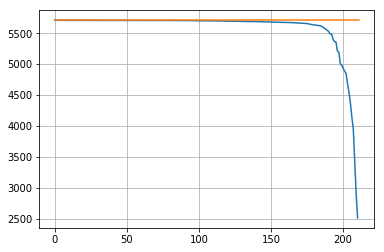

In [16]:
plt.plot(scores_feat_rank) # list(range(len(scores_feat_rank)))
plt.plot([0, len(scores_feat_rank)], [5705.8670533333325, 5705.8670533333325])
#plt.xscale('log')
plt.grid()
plt.show()

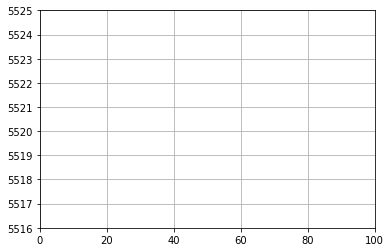

In [18]:
plt.plot(scores_feat_rank) # list(range(len(scores_feat_rank)))
plt.plot([0, len(scores_feat_rank)], [5705.8670533333325, 5705.8670533333325])
plt.xlim(0, 100)
plt.ylim(5516, 5525)
#plt.xscale('log')
plt.grid()
plt.show()

## Feature remove

### Feature remove list 1
Remove feature with shuffle scores >= non-shuffle score

In [ ]:
none_score = df_feat_shuffle_results.loc[df_feat_shuffle_results['col'] == 'none', 'mean'].values[0]
none_score

In [ ]:
feat_rm_1 = df_feat_shuffle_results.loc[df_feat_shuffle_results['mean'] > none_score, 'col'].tolist()

In [ ]:
print(len(feat_rm_1))
print('feat_rm_1 =', feat_rm_1)

### Feature remove list 2
Remove feature with shuffle scores last 50

In [ ]:
feat_rm_2 = [c for c in df_feat_shuffle_results['col'].tolist()[:51] if c != 'none']

In [ ]:
print(len(feat_rm_2))
print('feat_rm_2 =', feat_rm_2)

### Feature remove list 3
Remove feature with shuffle scores last 100

In [ ]:
feat_rm_3 = [c for c in df_feat_shuffle_results['col'].tolist()[:101] if c != 'none']

In [ ]:
print(len(feat_rm_3))
print('feat_rm_3 =', feat_rm_3)

### Feature shuffle importance 

In [ ]:
feat_rank_list = [c for c in df_feat_shuffle_results['col'].tolist() if c != 'none'];
print('feat_rank_list =', feat_rank_list)  # List of least important features

In [9]:
feat_shuffle_results_dict = {}
with open('exp-l04-per-area-results','r') as IFILE:
    for line in IFILE:
        try:
            score, feat = line.strip().split()
            feat_shuffle_results_dict[feat] = feat_shuffle_results_dict.get(feat, []) + [float(score)]
        except:
            print(line)
for key, val in feat_shuffle_results_dict.items():
    if len(val) != 3:
        print(key, val)